# Painting Interpolation Test

Test painting with LPT displacements only (no PM evolution), demonstrating artifacts when `r_center > box_size` and how `TelephotoInterp` and `OnionTiler` solve them.

This notebook covers:
- Flat-sky painting inside and outside the simulation box
- Spherical painting with different interpolation strategies
- Comparison of `NoInterp`, `TelephotoInterp`, and `OnionTiler`

## Environment Setup

Configure JAX memory allocation and import required libraries:

In [1]:
import os
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = '0.97'
os.environ["JAX_TRACEBACK_FILTERING"] = 'off'

import jax
import jax.numpy as jnp
import jax_cosmo as jc
import matplotlib.pyplot as plt

from fwd_model_tools import (
    gaussian_initial_conditions, lpt, Planck18, PaintingOptions, PositionUnit
)
from fwd_model_tools.pm.interp import NoInterp, TelephotoInterp, OnionTiler

/home/wassim/Projects/NBody/jax_cosmo/jax_cosmo/__init__.py:2: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution
/home/wassim/micromamba/envs/ffi11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Simulation Parameters

Define a small box to clearly demonstrate periodic artifacts when painting outside the box:

In [2]:
key = jax.random.PRNGKey(42)
mesh_size = (128, 128, 128)
box_size = (500.0, 500.0, 500.0)  # Small box to show artifacts clearly
nside = 128
flatsky_npix = (128, 128)
flat_field_size = (10.0, 10.0)  # degrees
observer_position = (0.5, 0.5, 0.5)

## Create Initial Conditions and Run LPT

Generate Gaussian initial conditions and compute LPT displacements at an early scale factor:

In [3]:
cosmo = Planck18()
initial_field = gaussian_initial_conditions(
    key, mesh_size, box_size, cosmo=cosmo,
    nside=nside,
    flatsky_npix=flatsky_npix,
    field_size=flat_field_size,
    observer_position=observer_position,
)

# Get displacement and momentum at early scale factor (a=0.5 -> z=1)
a_lpt = 0.5
dx_field, p_field = lpt(cosmo, initial_field, scale_factor_spec=a_lpt, order=1)

print(f"LPT computed at a={a_lpt} (z={jc.utils.a2z(a_lpt):.2f})")
print(f"Box size: {box_size[0]} Mpc/h")
print(f"Max comoving distance from observer: {initial_field.max_comoving_radius:.1f} Mpc/h")

LPT computed at a=0.5 (z=1.00)
Box size: 500.0 Mpc/h
Max comoving distance from observer: 250.0 Mpc/h


## Test 1: Flat Painting INSIDE Box (Baseline)

When `r_center` is inside the box, `NoInterp` works fine without artifacts:

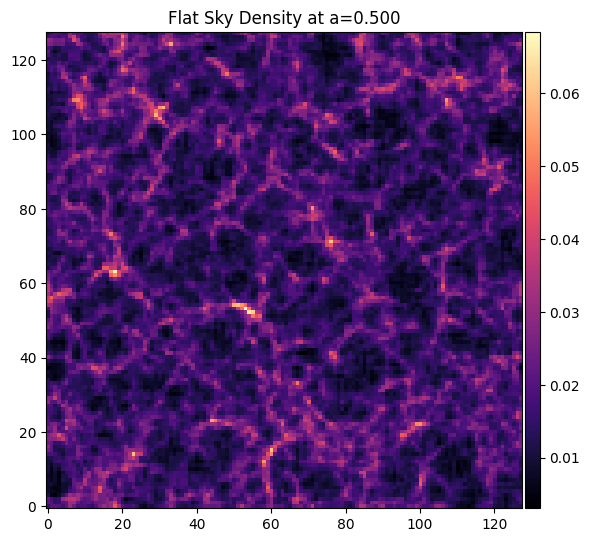

In [4]:
# r_center inside box - should work fine with NoInterp
r_center_inside = 200.0  # Mpc/h
density_width = 50.0

interp_nointerp = NoInterp()
state_inside = interp_nointerp.init(
    painting=PaintingOptions(target="flat"),
    ts=jnp.array([a_lpt]),
    r_centers=jnp.array([r_center_inside]),
    density_widths=jnp.array([density_width]),
    max_comoving_distance=dx_field.max_comoving_radius
)

result_inside, _ = interp_nointerp.apply(
    state=state_inside,
    t=a_lpt,
    y=(p_field, dx_field),
    cosmo=cosmo,
)

result_inside.show()

## Test 2: Flat Painting OUTSIDE Box with NoInterp (Shows Artifacts)

When `r_center > box_size`, `NoInterp` produces periodic artifacts because the same box content is repeated:

/home/wassim/micromamba/envs/ffi11/lib/python3.11/site-packages/jax/_src/debugging.py:201: UserWarning: 
            NoInterp does not support tiling. 
            Your furthest shell is at 625.0 Mpc/h, 
            but your box only extends to 250.0 Mpc/h.
            Your simulations will run but will have artifacts for the far shells.
        
  debug_callback_p.impl(


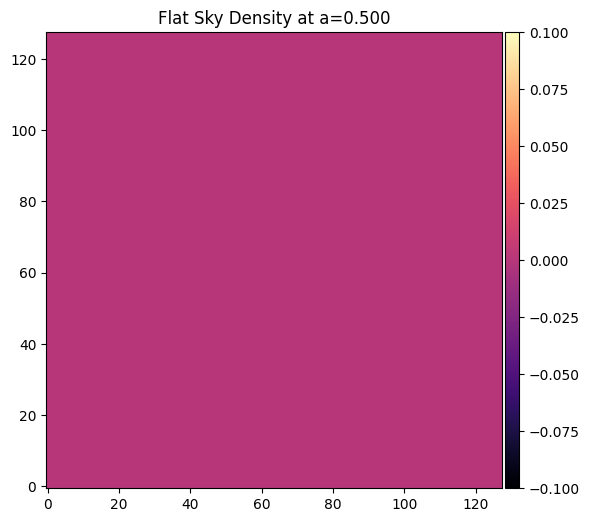

In [5]:
# r_center outside box - NoInterp will have artifacts
r_center_outside = 600.0  # Mpc/h > box_size

state_outside = interp_nointerp.init(
    painting=PaintingOptions(target="flat"),
    ts=jnp.array([a_lpt]),
    r_centers=jnp.array([r_center_outside]),
    density_widths=jnp.array([density_width]),
    max_comoving_distance=dx_field.max_comoving_radius
)

result_outside_nointerp, _ = interp_nointerp.apply(
    state=state_outside,
    t=a_lpt,
    y=(p_field, dx_field),
    cosmo=cosmo,
)

result_outside_nointerp.show()

## Test 3: Flat Painting OUTSIDE Box with TelephotoInterp

`TelephotoInterp` applies rotation decorrelation to break the periodicity for narrow field-of-view observations:

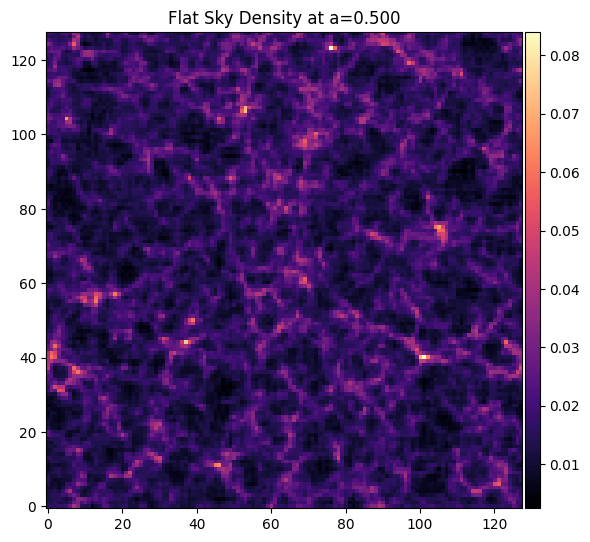

In [6]:
interp_telephoto = TelephotoInterp()
state_telephoto = interp_telephoto.init(
    painting=PaintingOptions(target="flat"),
    ts=jnp.array([a_lpt]),
    r_centers=jnp.array([r_center_outside]),
    density_widths=jnp.array([density_width]),
    max_comoving_distance=dx_field.max_comoving_radius
)

result_outside_telephoto, _ = interp_telephoto.apply(
    state=state_telephoto,
    t=a_lpt,
    y=(p_field, dx_field),
    cosmo=cosmo,
)

result_outside_telephoto.show()

## Comparison: Flat NoInterp vs TelephotoInterp

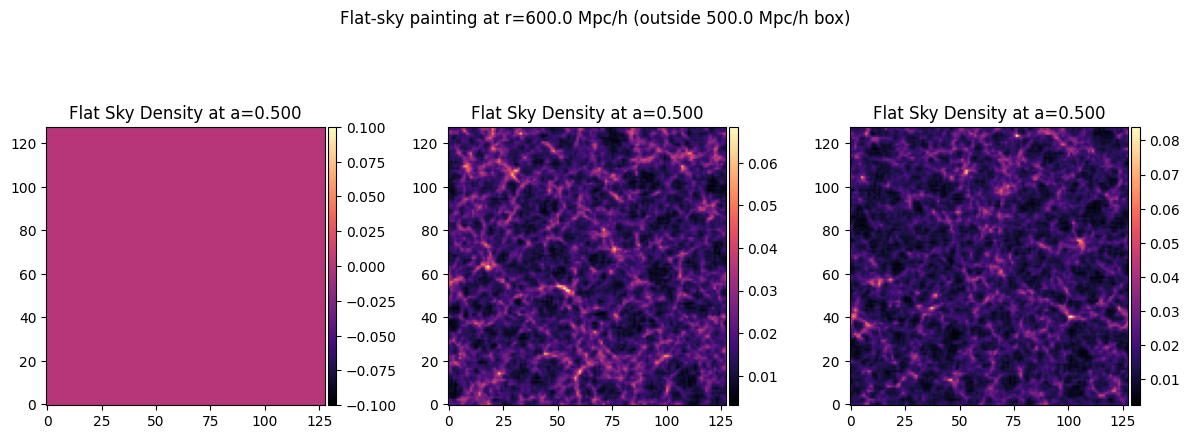

In [7]:
fig, axes = plt.subplots(1, 3, figsize=(12, 5))

result_outside_nointerp.plot(ax=axes[0])
result_inside.plot(ax=axes[1])
result_outside_telephoto.plot(ax=axes[2])

plt.suptitle(f'Flat-sky painting at r={r_center_outside} Mpc/h (outside {box_size[0]} Mpc/h box)')
plt.tight_layout()
plt.show()

## Test 4: Spherical Painting INSIDE Box (Baseline)

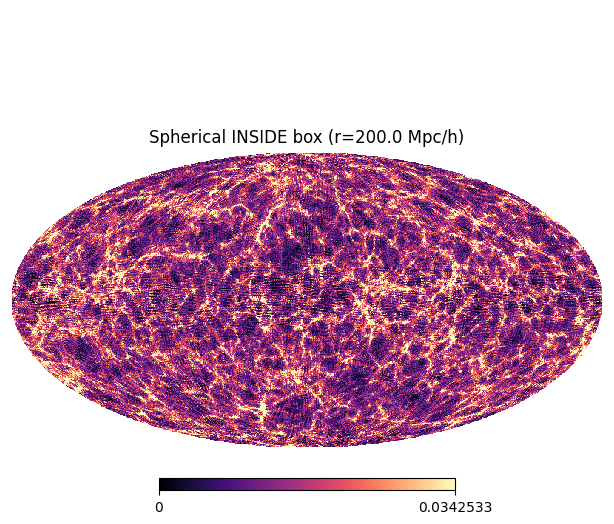

In [8]:
state_sph_inside = interp_nointerp.init(
    painting=PaintingOptions(target="spherical", scheme="bilinear"),
    ts=jnp.array([a_lpt]),
    r_centers=jnp.array([r_center_inside]),
    density_widths=jnp.array([density_width]),
    max_comoving_distance=dx_field.max_comoving_radius,
)

result_sph_inside, _ = interp_nointerp.apply(
    state=state_sph_inside,
    t=a_lpt,
    y=(p_field, dx_field),
    cosmo=cosmo,
)

result_sph_inside.show(titles=[f'Spherical INSIDE box (r={r_center_inside} Mpc/h)'])

## Test 5: Spherical Painting OUTSIDE Box with NoInterp (Shows Artifacts)

In [9]:
cosmo = Planck18()
initial_field = gaussian_initial_conditions(
    key, mesh_size, box_size, cosmo=cosmo,
    nside=nside,
    flatsky_npix=flatsky_npix,
    field_size=flat_field_size,
    observer_position=observer_position,
)

# Get displacement and momentum at early scale factor (a=0.5 -> z=1)
a_lpt = 0.5
dx_field, p_field = lpt(cosmo, initial_field, scale_factor_spec=a_lpt, order=1)

print(f"LPT computed at a={a_lpt} (z={jc.utils.a2z(a_lpt):.2f})")
print(f"Box size: {box_size[0]} Mpc/h")
print(f"Max comoving distance from observer: {initial_field.max_comoving_radius:.1f} Mpc/h")

LPT computed at a=0.5 (z=1.00)
Box size: 500.0 Mpc/h
Max comoving distance from observer: 250.0 Mpc/h


/home/wassim/micromamba/envs/ffi11/lib/python3.11/site-packages/jax/_src/debugging.py:201: UserWarning: 
            NoInterp does not support tiling. 
            Your furthest shell is at 625.0 Mpc/h, 
            but your box only extends to 250.0 Mpc/h.
            Your simulations will run but will have artifacts for the far shells.
        
  debug_callback_p.impl(


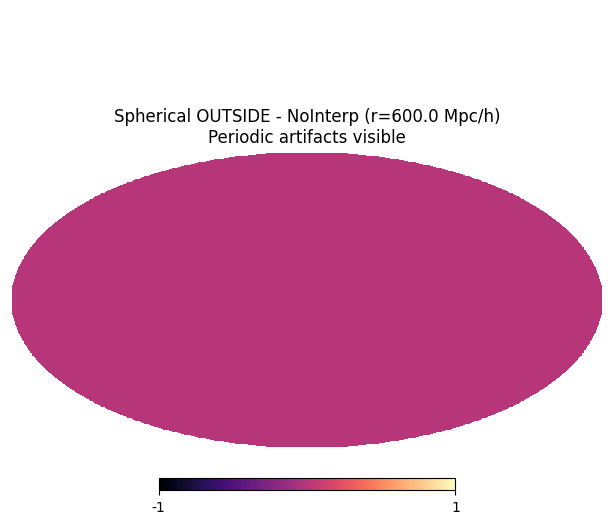

In [10]:
state_sph_outside = interp_nointerp.init(
    painting=PaintingOptions(target="spherical", scheme="bilinear"),
    ts=jnp.array([a_lpt]),
    r_centers=jnp.array([r_center_outside]),
    density_widths=jnp.array([density_width]),
    max_comoving_distance=dx_field.max_comoving_radius,
)

result_sph_outside_nointerp, _ = interp_nointerp.apply(
    state=state_sph_outside,
    t=a_lpt,
    y=(p_field, dx_field),
    cosmo=cosmo,
)

result_sph_outside_nointerp.show(titles=[f'Spherical OUTSIDE - NoInterp (r={r_center_outside} Mpc/h)\nPeriodic artifacts visible'])

## Test 6: Spherical Painting OUTSIDE Box with TelephotoInterp

Note: TelephotoInterp will warn that it's designed for flat-sky observations:

/home/wassim/Projects/NBody/fwd_model_tools/src/fwd_model_tools/pm/interp.py:520: UserWarning: 
            TelephotoInterp is designed for narrow FOV flat-sky projections.
            Using it for spherical painting will cause significant artifacts.
            use for illustriative purposes only.
            
  warnings.warn("""


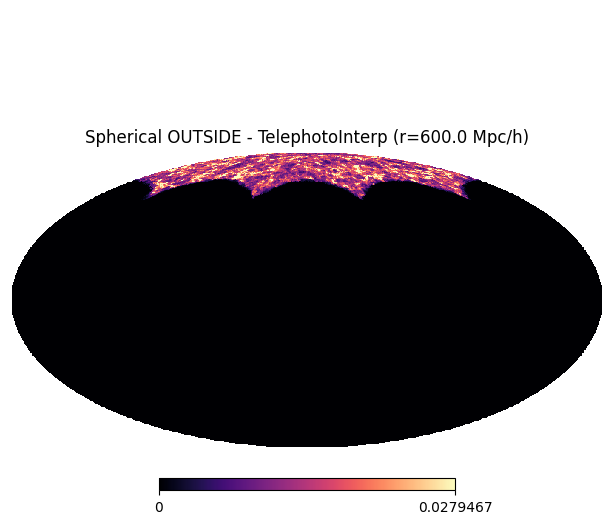

In [11]:
state_sph_telephoto = interp_telephoto.init(
    painting=PaintingOptions(target="spherical", scheme="bilinear"),
    ts=jnp.array([a_lpt]),
    r_centers=jnp.array([r_center_outside]),
    density_widths=jnp.array([density_width]),
    max_comoving_distance=dx_field.max_comoving_radius,
)

result_sph_outside_telephoto, _ = interp_telephoto.apply(
    state=state_sph_telephoto,
    t=a_lpt,
    y=(p_field, dx_field),
    cosmo=cosmo,
)

result_sph_outside_telephoto.show(titles=[f'Spherical OUTSIDE - TelephotoInterp (r={r_center_outside} Mpc/h)'])

## Test 7: Spherical Painting OUTSIDE Box with OnionTiler (Best for Full-Sky)

`OnionTiler` uses 27-tile decorrelation, which is optimal for full-sky spherical observations:

In [12]:
cosmo = Planck18()
initial_field = gaussian_initial_conditions(
    key, mesh_size, box_size, cosmo=cosmo,
    nside=nside,
    flatsky_npix=flatsky_npix,
    field_size=flat_field_size,
    observer_position=observer_position,
)

# Get displacement and momentum at early scale factor (a=0.5 -> z=1)
a_lpt = 0.5
dx_field, p_field = lpt(cosmo, initial_field, scale_factor_spec=a_lpt, order=1)

print(f"LPT computed at a={a_lpt} (z={jc.utils.a2z(a_lpt):.2f})")
print(f"Box size: {box_size[0]} Mpc/h")
print(f"Max comoving distance from observer: {initial_field.max_comoving_radius:.1f} Mpc/h")

LPT computed at a=0.5 (z=1.00)
Box size: 500.0 Mpc/h
Max comoving distance from observer: 250.0 Mpc/h


In [13]:
mpc = dx_field.to(PositionUnit.MPC_H)

positions_phys = dx_field * jnp.array(box_size) / jnp.array(mesh_size)

(positions_phys - mpc).max()

Array(0., dtype=float64)

doing shift [0. 0. 0.] and rotation 
[[ 0  0 -1]
 [ 1  0  0]
 [ 0  1  0]]
max mpc before shift 260.05874394600113 and after shift   260.05874394600113
doing shift [  0.   0. 500.] and rotation 
[[ 0  1  0]
 [ 0  0 -1]
 [-1  0  0]]
max mpc before shift 260.05874394600113 and after shift   757.9593386095273
doing shift [   0.    0. -500.] and rotation 
[[1 0 0]
 [0 0 1]
 [0 1 0]]
max mpc before shift 258.87142229150004 and after shift   258.6412405237467
doing shift [  0. 500.   0.] and rotation 
[[ 0  0  1]
 [ 0 -1  0]
 [-1  0  0]]
max mpc before shift 259.3695386241913 and after shift   759.3695386241914
doing shift [  0. 500. 500.] and rotation 
[[0 1 0]
 [1 0 0]
 [0 0 1]]
max mpc before shift 258.87142229150004 and after shift   758.6412405237468
doing shift [   0.  500. -500.] and rotation 
[[ 1  0  0]
 [ 0  0  1]
 [ 0 -1  0]]
max mpc before shift 259.3695386241913 and after shift   755.6459658006054
doing shift [   0. -500.    0.] and rotation 
[[ 0  0 -1]
 [ 0 -1  0]
 [-1  0  0]]


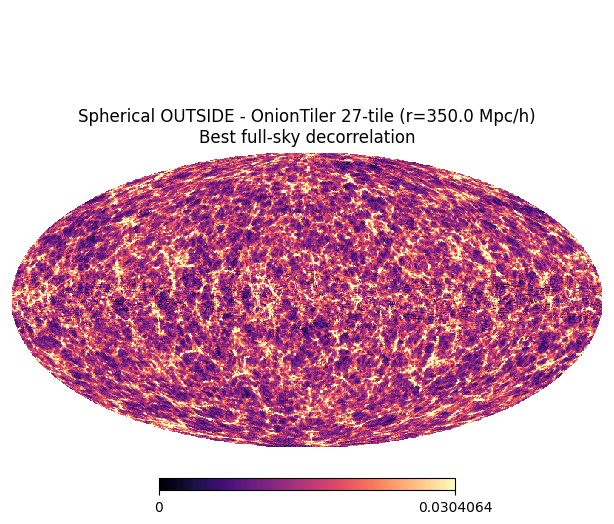

In [14]:
r_center_outside = 350.
interp_onion = OnionTiler()
state_sph_onion = interp_onion.init(
    painting=PaintingOptions(target="spherical", scheme="bilinear"),
    ts=jnp.array([a_lpt]),
    r_centers=jnp.array([r_center_outside]),
    density_widths=jnp.array([density_width]),
    max_comoving_distance=dx_field.max_comoving_radius,
)

result_sph_outside_onion, _ = interp_onion.apply(
    state=state_sph_onion,
    t=a_lpt,
    y=(p_field, dx_field),
    cosmo=cosmo,
)

result_sph_outside_onion.show(titles=[f'Spherical OUTSIDE - OnionTiler 27-tile (r={r_center_outside} Mpc/h)\nBest full-sky decorrelation'])

## Comparison: All Spherical Methods

/tmp/ipykernel_250844/1349575574.py:9: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


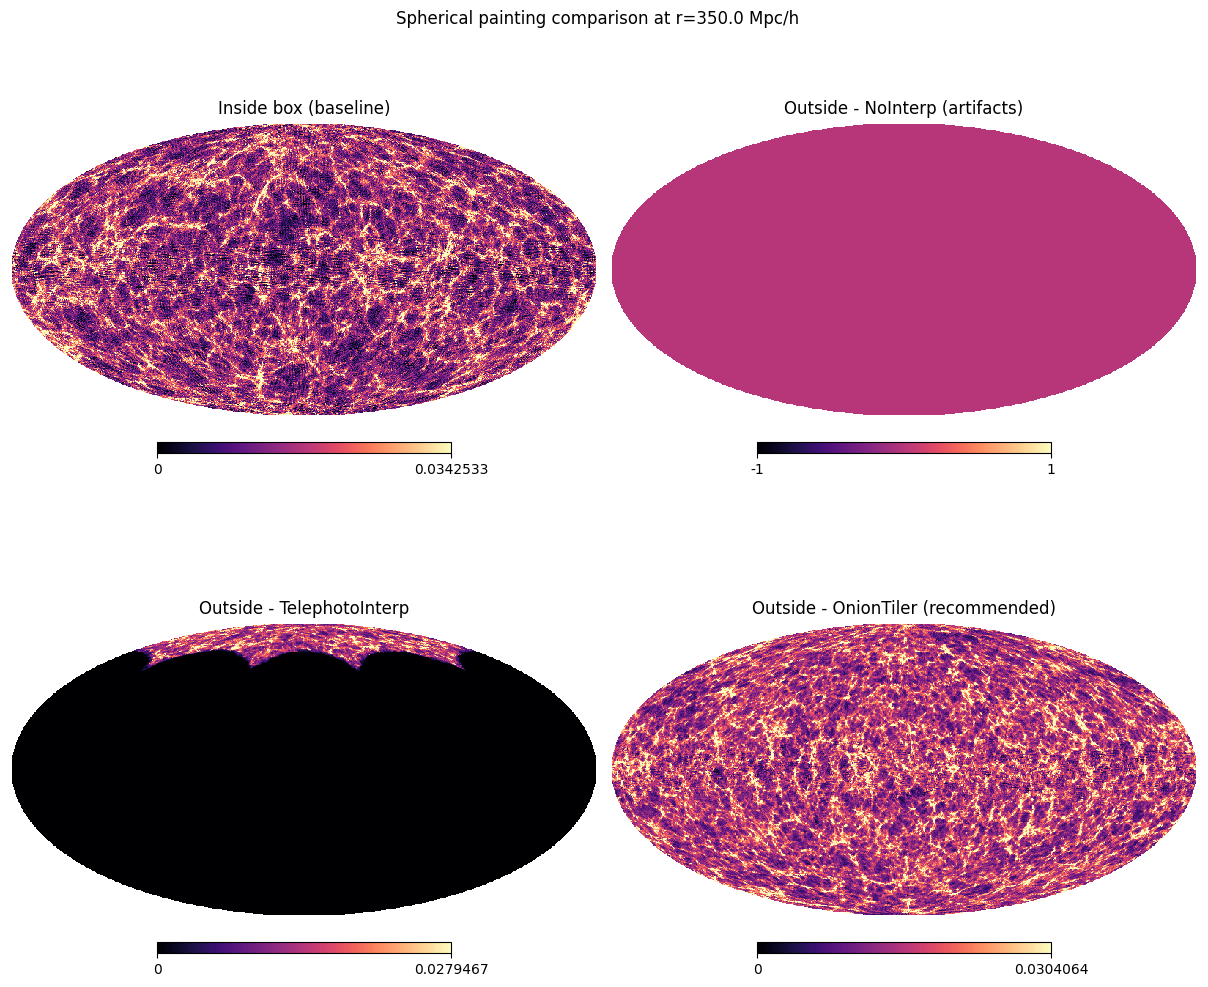

In [15]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

result_sph_inside.plot(ax=axes[0, 0], titles=['Inside box (baseline)'])
result_sph_outside_nointerp.plot(ax=axes[0, 1], titles=['Outside - NoInterp (artifacts)'])
result_sph_outside_telephoto.plot(ax=axes[1, 0], titles=['Outside - TelephotoInterp'])
result_sph_outside_onion.plot(ax=axes[1, 1], titles=['Outside - OnionTiler (recommended)'])

plt.suptitle(f'Spherical painting comparison at r={r_center_outside} Mpc/h')
plt.tight_layout()
plt.show()